# Interactive Porto Insights - A Plot.ly Tutorial

참고 : https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

브라질에서 세번째로 큰 보험회사 Porto Seguro가 주최하는 대회이며, 운전자가 내년에 보험금을 청구하기 시작할 확률을 예측하는 과제이다. <br><br>
python의 시각화 라이브러리인 Plot.ly는 많은 plot이 있다.
- Simple horizontal bar plot : target 값의 분포 파악
- Correlation Heatmap plot : 다양한 변수간 상관관계 파악
- Scatter plot : RandomForest와 Gradient-Boosted 모델에서 얻은 변수 중요도 비교
- Vertical bar plot : 다양한 변수의 중요도를 내림차순 나열
- 3D Scatter plot

전체 코드 요약
1. Data Quality Checks : 값이 -1인 결측값이나 null값을 시각화하고 평가
2. Feature inspection and filtering : 상관관계와 target값에 대한 변수 상호 중요도 plot, 이항 / 범주형 / 기타 변수 파악
3. Feature inportance ranking via learning models : Random Forest와 Gradient Boost 모델 구축을 통해 학습 과정에 따라 변수의 순위 지정

# 1st

In [5]:
# 관련 파이썬 모듈 임포트
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

Pandas를 사용해 제공받은 training data를 불러오자.

In [6]:
train = pd.read_csv('../input/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [9]:
# train dataset의 행과 열의 수 확인
rows = train.shape[0]
columns = train.shape[1]
print('train 데이터셋은 {0}개 행과 {1}개 열을 갖는다.'.format(rows,columns))

train 데이터셋은 595212개 행과 59개 열을 갖는다.


# 1. Data Quality checks

## 1.1. Data checks

### 1.1.1 Null or missing values check

train 데이터셋에 null값이 있는지 확인해보자.

In [10]:
# 모든 열에서 isnull 확인을 위해 any() 를 두 번 적용한다.
train.isnull().any().any()

False

Null값 확인 결과 False를 반환하지만, -1 값이 변수가 결측된 것을 나타내기 때문에 실제로 결측값이 없다고 볼 수는 없다. 따라서 Porto Seguro가 데이터의 모든 null값을 -1값으로 대체한 것을 알 수 있다. 이제 데이터에 결측값이 있는지 확인해보자.

다음과 같이 모든 -1 값을 null로 대체하여 어떤 열이 -1 값을 갖고있는지 확인할 수 있다.

In [11]:
train_copy = train
train_copy = train_copy.replace(-1,np.NaN)

다음으로 dataset에서 결측값을 시각화하기 유용한 Missingno 패키지를 사용한다.

<AxesSubplot:>

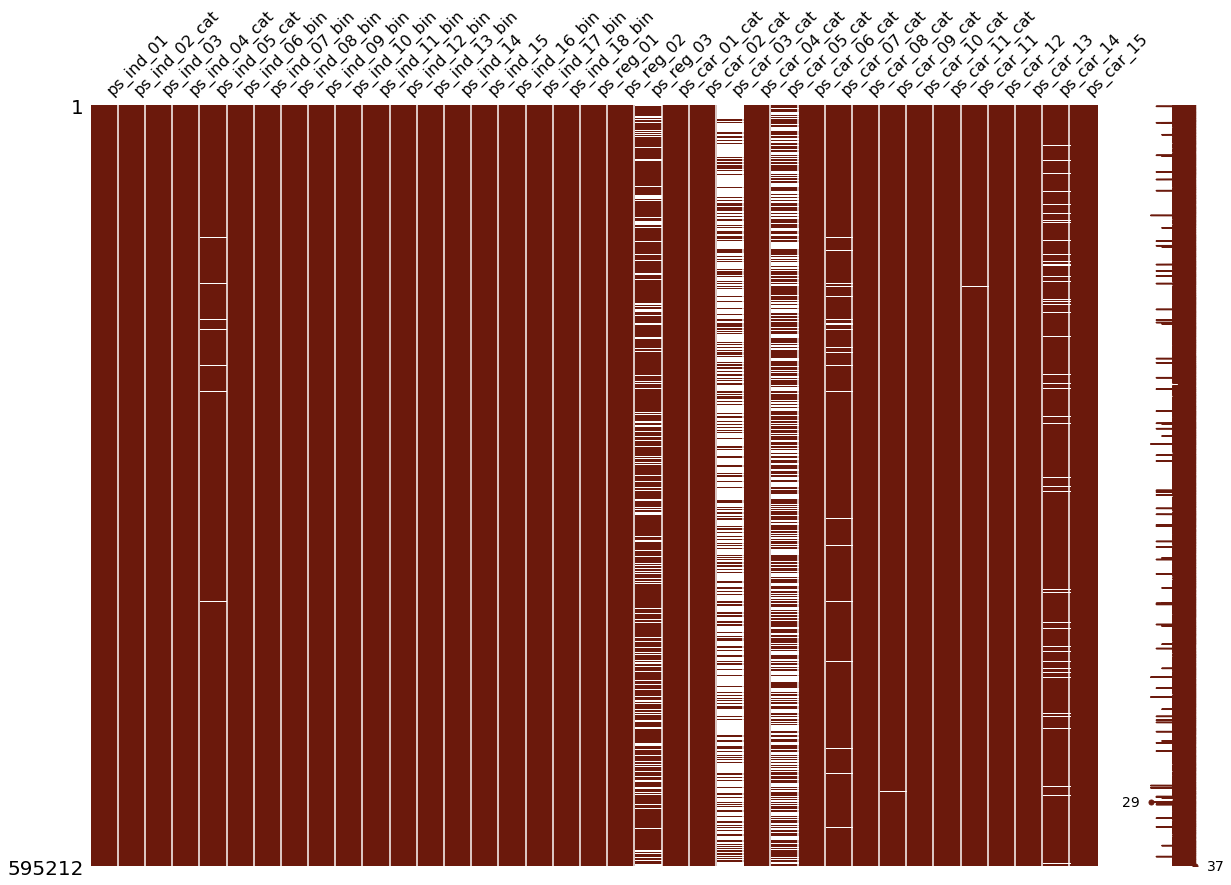

In [19]:
import missingno as msno
# 열의 null값이나 결측값 확인
msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))

시각화를 통해 결측값을 분명히 볼 수 있고, 빈 흰색 줄(결측값)은 특정 열의 null값을 보여준다. 여기서 59개의 변수 중 7개의 변수가 null값을 갖고 있는 것을 알 수 있다. 이는 missingno matrix plot이 약 40개의 홀수 변수에만 적합할 수 있으므로 나머지 5개의 null 값이 있는 열은 제외되었다. 모든 null값을 시각화하려면 데이터프레임을 자르거나 figsize를 조정한다.<br>

관측된 null 값을 가진 7개의 열은 ps_ind_05_cat, ps_reg_03, ps_car_03_cat, par_05_cat, ps_car_07_cat, ps_car_09_cat, ps_car_14 이다. 대부분 결측값이 있는 변수는 _cat 접미사가 붙는다. ps_reg_03, ps_car_03_cat, ps_car_05 변수는 null 값이 많으므로 -1을 NaN값으로 대체하는 것은 좋지 않을 수 있다.

### 1.1.2. Target variable inspection

일반적으로 수행되는 또 다른 표준 검사는 target 변수와 관련되고, 열 이름은 편하게 'target'이라고 한다. 데이터를 target에 가장 잘 매핑하는 함수를 학습시키기 위해 주어진 데이터(id 제외 모든 tarin data)와 함께 지도학습 모델에 사용한다.

In [26]:
data = [go.Bar(x = train['target'].value_counts().index.values,
              y = train['target'].value_counts().values,
              text = 'Distribution of target varibale')]
layout = go.Layout(title = 'Target variable distribution')
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='basic-bar')

target 변수가 너무 불균형해서 유의해야한다. 

### 1.1.3. Datatype check

train 데이터셋이 어떤 데이터유형(integer/character/float)으로 구성돼있는지 확인한다. Collections 모듈의 Counter 메소드를 통해 고유한 데이터유형의 수를 얻는다.

In [27]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급했듯, train 데이터셋은 59개의 열로 이루어져있고, 변수/열은 integer와 float 두 가지 데이터 유형으로만 이루어져있다. <br>
또한 제공된 데이터의 변수 이름엔 _bin, _cat, _reg와 같은 약어로 접미사가 있다. _bin은 이진 변수, 나머지는 연속형이나 순서형 변수를 나타낸다. float 값(아마 연속형 변수)과 integer 값(아마 이항, 범주형, 순서형 변수)를 살펴보며 단순화해야한다.

In [28]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

## 1.2. Plots

### 1.2.1. Correlation plots

변수간 선형 관계와 몇 가지 정보를 얻기 위해 선형 상관관계도를 생성해보자. 통계 시각화 패키지 seaborn을 사용해 상관관계 값을 heatmap으로 그린다. Pandas 데이터프레임의 corr() 내장 메소드를 통해 피어슨 상관관계를 편히 계산할 수 있고, seaborn의 상관관계도도 heatmap이라는 단어만 있으면 호출할 수 있다.

#### Correltaion of float features

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

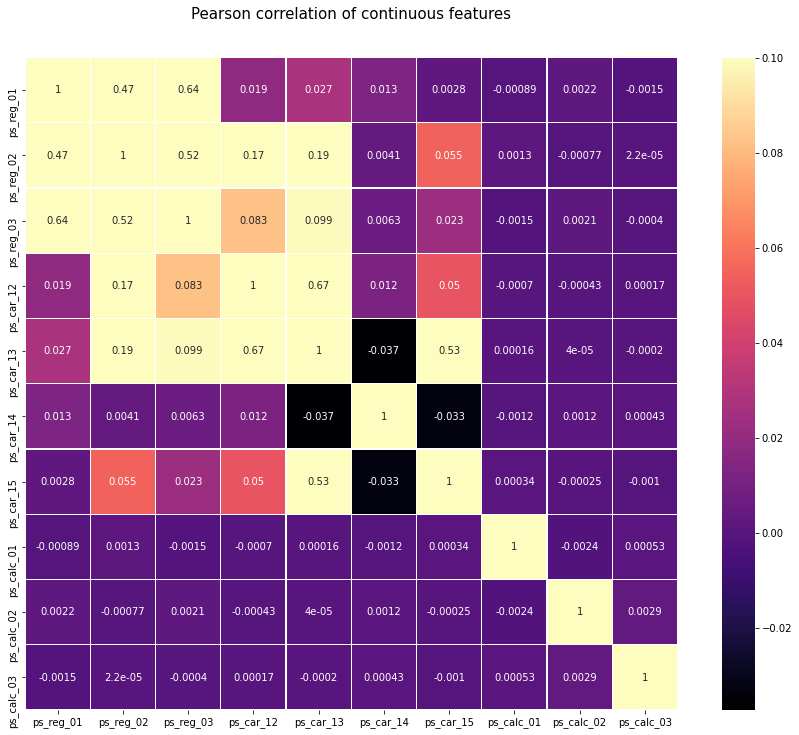

In [31]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features',y=1.05,size=15)  ### 연속형 변수간 피어슨 상관관계도
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=0.1,square=True,
           cmap=colormap,linecolor='white',annot=True)

상관관계도를 통해 대부분의 변수가 서로 상관관계가 없는 것을 알 수 있다. 양의 선형 상관관계를 나타내는 변수 쌍은 (ps_reg_01,ps_reg_03), (ps_reg_02, ps_reg_03), (ps_car_12, ps_car_13), (ps_car_13, ps_car_15) 이다.

#### Correlations of integer features

integer 데이터유형의 열에 대해 Plotly 라이브러리를 사용해 상호적으로 상관관계가 어떻게 나타나는지 heatmap을 생성해보자. 이전 Plotly plot처럼 go.Heatmap 을 호출해 heatmap 객체를 얻는다. 여기선 서로 다른 세 축에 값을 제공해야 하는데, x와 y축은 열 이름을 주고 z축을 통해 상관관계 값을 알 수 있다.

In [35]:
# train_int = train_int.drop(['id','target'],axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.0,size=15)
# sns.heatmap(train_cat.corr(), linewiedths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)

data = [go.Heatmap(z = train_int.corr().values,
                  x = train_int.columns.values,
                  y = train_int.columns.values,
                  colorscale='Viridis',reversescale=False,opacity=1.0)]
layout = go.Layout(title = 'Pearson Correlation of Integer-type features',
                  xaxis = dict(ticks='',nticks=36),yaxis=dict(ticks=''),width=900,height=700)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='labelled-heatmap')

마찬가지로, 많은 열이 서로 상관관계가 전혀 없다. 이는 주성분분석(PCA)와 같이 차원 축소 변환을 할 때 일정 수준의 상관관계가 필요할 수 있으므로 유용한 결과다. 음의 상관관계인 변수는 ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin 이다. <br>
흥미로운 점은 이전에 ps_car_03_cat, ps_car_05_cat이 결측값이나 null값이 많았지만 이 두 변수가 서로 강한 양의 상관관계를 보인다.

### 1.2.2. Mutual information plots

mutual information은 target 변수와 그것을 계산하는 해당 변수간 상호 정보를 알 수 있어 유용하다. 분류 문제에서 sklearn의 mutual_info_classif 메소드를 통해 두 랜덤 변수간 종속성을 0(서로 독립)에서 높은 값(종속)의 범주로 측정할 수 있다. 따라서 변수가 target의 정보를 얼마나 포함하는지 알 수 있다.<br>
sklearn의 mutual_info_classif는 k-nearest neighbors 거리의 엔트로피 추정에 기반한 비모수 방법에 의존한다.

In [37]:
mf = mutual_info_classif(train_float.values, train.target.values,n_neighbors=3,random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


# 2. Feature inspection and filtering

## 2.1. Binary features inspection

데이터는 이진수 값만 있는 열도 있다. 이러한 이항 값이 포함된 모든 열을 저장하고 다음과 같이 이항값의 수직 plotly barplot을 생성한다.

In [41]:
bin_col = [col for col in train.columns if '_bin' in col]  ### _bin 들어간 열이름
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())  ### 각 열의 값이 0인 데이터 개수
    one_list.append((train[col]==1).sum())  ### 각 열의 값이 1인 데이터 개수

print(zero_list)
print(one_list)

[360852, 442223, 497644, 484917, 594990, 594205, 589594, 594648, 201882, 523143, 503879, 522342, 221514, 265356, 424278, 387469, 503955]
[234360, 152989, 97568, 110295, 222, 1007, 5618, 564, 393330, 72069, 91333, 72870, 373698, 329856, 170934, 207743, 91257]


In [42]:
trace1 = go.Bar(x=bin_col, y=zero_list, name='Zero count')
trace2 = go.Bar(x=bin_col, y=one_list, name='One count')

data = [trace1, trace2]
layout = go.Layout(barmode='stack',title='Count of 1 and 0 in binary variables')
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='stacked-bar')

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 변수는 0이 거의 대부분이다. 이것은 변수가 target에 대한 정보를 많이 포함하고 있지 않는다는 것이기 때문에 변수가 유용한지 의문이 제기된다.

## 2.2. Categorical and Ordinal feature inspection

_cat 접미사가 있는 범주형 변수를 살펴보자.....인데 코드가 없다.

# 3. Feature inportance ranking via learning models

## 3.1. Feature importance via Random Forest

이제 Random Forest에 train data를 적합하여 모델을 구현하고 학습이 끝나면 변수의 순위를 확인해보자. 이것은 앙상블 모델(약한 의사결정나무 학습기를 Bootstrap에 적용한 앙상블)을 사용하는 빠른 방법이고, 이 앙상블 모델은 유용한 변수 중요도를 얻는 데 파라미터를 많이 조정하지 않아도 되고 target 불균형에 꽤 강력하다. Random Forest를 호출해보자.

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,max_depth=8,min_samples_leaf=4,max_features=0.2,random_state=0)
rf.fit(train.drop(['id','target'],axis=1),train.target)
features = train.drop(['id','target'],axis=1).columns.values
print('-------학습 완료-------')

-------학습 완료-------


### 3.1.1. Plot.ly Scatter Plot of feature importances

RandomForest를  학습시킨 후, 'featureimportances'를 호출해 변수 중요도 리스트를 얻고 Scatter plot을 그릴 수 있다. <br>
여기선 Scatter 명령을 호출하고 이전 Plotly plot에 따라 x와 y축을 정의해야한다. scatter plot에서 marker은 scatter point의 크기, 색상, 스케일을 정의한다.

In [45]:
# Scatter plot
trace = go.Scatter(y=rf.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,color=rf.feature_importances_,colorscale='Portland',showscale=True),text=features)
data = [trace]

layout = go.Layout(autosize=True,title='Random Forest Feature Importance',hovermode='closest',
                  xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                  yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

또한 plotly barplots를 통해 중요도 순위가 매겨진 모든 변수의 목록을 정렬할 수 있다.

In [47]:
x,y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_,features),reverse=False)))
trace2 = go.Bar(x=x,y=y,marker=dict(color=x,colorscale='Viridis',reversescale=True),
               name='Random Forest Feature importance', orientation='h')
layout = dict(title='Barplot of Feature importances',width=900,height=2000,
             yaxis=dict(showgrid=False,showline=False,showticklabels=True))
fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

### 3.1.2. Decision Tree visualization

단순성을 위해 max_depth=3 인 의사결정나무를 적합하면, 의사결정 가지에서 3개의 수준만 볼 수 있다. skelarn의 'export_graphviz'에서 시각화를 그래프로 그려 시각화된 나무 이미지를 내보내고 가져온다.

In [61]:
from sklearn import tree
from IPython.display import Image as PIamge
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id','target'],axis=1),train.target)

# 학습된 모델을 .dot 파일로 내보내기
with open('tree1.dot','w') as f:
    f = tree.export_graphviz(decision_tree,out_file=f,max_depth=4,impurity=False,
                            feature_names=train.drop(['id','target'],axis=1).columns.values,
                            class_names=['No','Yes'],rounded=True,filled=True)

# 웹 노트북에 표시할 수 있도록 .dot을 .png로 변환
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'],shell=True) ### 에러, shell 임의 추가

# PIL을 통해 차트에 주석 달기
img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

CalledProcessError: Command '['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png']' returned non-zero exit status 1.

## Feature importance via Gradient Boosting model

단지 호기심으로 변수 중요도를 얻기 위해 또 다른 학습 방법을 시도해보자. 이번에는 Gradient Boosting 분류기를 사용해 train 데이터를 적합한다. Gradient Boosting은 전진선택법으로 진행되며, 각 단계에서 회귀 나무들이 손실함수의 gradient에 적합된다.

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100,max_depth=3,min_samples_leaf=4,max_features=0.2,random_state=0)
gb.fit(train.drop(['id','target'],axis=1), train.target)
geatures = train.drop(['id','target'],axis=1).columns.values

print('------학습완료------')

------학습완료------


In [65]:
# Scatter plot
trace = go.Scatter(y=gb.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,color=gb.feature_importances_,colorscale='Portland',showscale=True),text=features)
data = [trace]

layout = go.Layout(autosize=True,title='Gradient Boosting Machine Feature Importace',hovermode='closest',
                   xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                   yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),showlegend=False)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [67]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_,features),reverse = False)))
trace2 = go.Bar(x=x ,y=y,marker=dict(color=x,colorscale = 'Viridis',reversescale = True),
    name='Gradient Boosting Classifer Feature importance',orientation='h',)

layout = dict(title='Barplot of Feature importances',width = 900, height = 2000,
              yaxis=dict(showgrid=False,showline=False,showticklabels=True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

Random Forest와 Gradient Boosting 학습 모델에서 모두 가장 중요한 변수는 ps_car_13이라는 것을 알 수 있다.